In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 
## Homework 4: Classification: Predicting College Admissions

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
# RUN THIS CELL
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models**](#part1)

- [**Question 2: Interpretable modeling**](#part2)

- [**Question 3: Harvard and Yale?**](#part3)

- [**Question 4: Building predictive models for admitted**](#part4)

- [**Question 5: Evaluating results**](#part5)

- [**Question 6: BONUS!**](#part6)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges: Harvard and Yale.

The data are provided in the file `data/college_admissions.csv` and were scraped in 2022 from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test_score**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **harvard**: a categorical variable for school applied to: 1 = Harvard, 0 = Yale
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models.


**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty=None`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.


In [5]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################
np.random.seed(121)

college = pd.read_csv("data/college_admissions.csv")

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["admitted"],
)

print(college.shape)
print(college_train.shape, college_test.shape)
display(college_train.head())
college_train.info()

# Separate predictors from response
X_train, y_train = college_train.drop(columns=["admitted"]), college_train["admitted"]
X_test, y_test = college_test.drop(columns=["admitted"]), college_test["admitted"]

(1871, 16)
(1496, 16) (375, 16)


,id,admitted,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,program,add_info,harvard
192,NYFN0GE0KK,1,2310,7,5.000,5,3.98,0,0,0,0,0,0,Economics,Activities Activity Position Honors Grade Levels Approximate Time When Participated Participate ...,1
652,50FWDZ3MBF,1,2010,3,4.333,3,3.75,1,1,0,0,0,0,History Political Science,Drama Club Co founder of a Community Outreach Organization called Los Amigos volunteered helped ...,1
593,KYYHQRHBV9,0,2080,5,4.200,2,3.85,0,0,0,0,0,0,Biology Pre Med,moderate a few sports and clubs and a part time jobfamily circumstances positive,1
331,JQ8O4AV4VM,0,2250,0,0.000,2,4.00,0,0,0,0,0,0,Physics,NaN,1
1117,SJUQZVBA7K,0,2230,4,4.000,5,3.96,1,0,0,0,1,0,Chemistry Chemical Engineering,MUN Advisor 12 10 National Honors Society 12 10 California Scholarship Federation 12 9 Book Club...,0


<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 192 to 1296
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1496 non-null   object 
 1   admitted       1496 non-null   int64  
 2   test_score     1496 non-null   int64  
 3   ap             1496 non-null   int64  
 4   avg_ap         1496 non-null   float64
 5   sat_subjects   1496 non-null   int64  
 6   gpa            1496 non-null   float64
 7   female         1496 non-null   int64  
 8   minority       1496 non-null   int64  
 9   international  1496 non-null   int64  
 10  sports         1496 non-null   int64  
 11  early_app      1496 non-null   int64  
 12  alumni         1496 non-null   int64  
 13  program        1298 non-null   object 
 14  add_info       949 non-null    object 
 15  harvard        1496 non-null   int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 198.7+ KB


<div class='exercise-r'>

**Q1.1** Consider a baseline, "naive" model that predicts that *ALL* applicants belong to the same class. This class prediction is *not* determined by an applicant's feature values, but rather by the proportion of observations in the training data belonging to each class.

Calculate the accuracy of this naive model on the training data and store it in `naive_train_acc`.

**NOTE:** For this assignment, use the convention that accuracies range from 0 to 1 (to be consistant with sklearn).
    
</div>

In [6]:
# get counts for 0s and 1s
college_train["admitted"].value_counts(normalize=True)

admitted
0    0.73
1    0.27
Name: proportion, dtype: float64

In [7]:
# since more 0s => naive model predicts 0 for all
naive_train_acc = (college_train['admitted'] == 0).mean()
naive_train_acc

np.float64(0.7299465240641712)

In [8]:
print("Naive Classification Model Based on Training Proportions")
print(f"\tTrain Accuracy: {naive_train_acc:.4f}")

Naive Classification Model Based on Training Proportions
	Train Accuracy: 0.7299


In [9]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.2** Let's investigate how each of our 12 predictors is associated with whether or not an applicant is admitted into the college to which they applied (`admitted`). To this end, create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a grid of subplots with 3 columns and 4 rows.

</div>

C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\3824402731.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=college_train_predictors, y=col, x=college_train["admitted"], ax=ax[i], palette={"0": "blue", "1": "orange"})
C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\3824402731.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=college_train_predictors, y=col, x=college_train["admitted"], ax=ax[i], palette={"0": "blue", "1": "orange"})
C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\3824402731.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sa

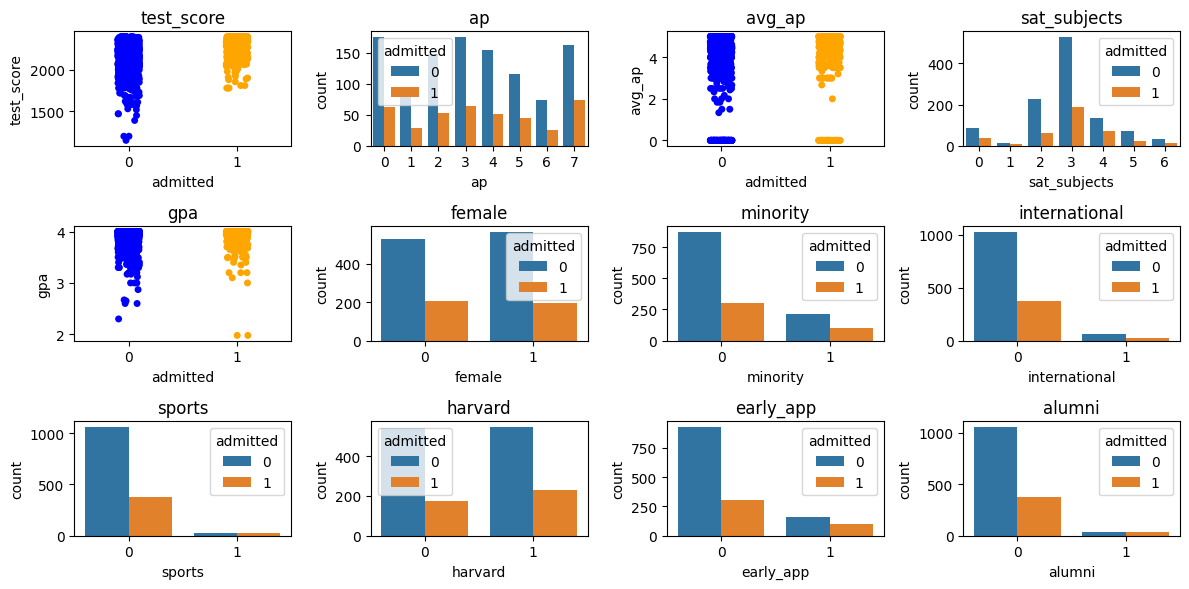

In [10]:
# Plotting
# get correct predictor columns
columns = [
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
college_train_predictors = college_train[columns]

fig, ax = plt.subplots(3, 4, figsize=(12, 6))
ax = ax.ravel()

# plot each column against the target
for i, col in enumerate(college_train_predictors.columns):
    # check if categorical
    if college_train_predictors[col].dtype == 'object' or college_train_predictors[col].nunique() < 10:
        sns.countplot(data=college_train, x=col, hue="admitted", ax=ax[i])
    else: 
        sns.stripplot(data=college_train_predictors, y=col, x=college_train["admitted"], ax=ax[i], palette={"0": "blue", "1": "orange"})
    ax[i].set_title(col)
    plt.tight_layout()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

test_score seems to have the most potential for predicting admitted. I believe this because the continuous variable provides data for models like logistic regression to create a decision boundary based on the linear term in the logistic regression formula. Additionally, the data for this plot seems more correlated with admission than other metrics with higher variance like GPA or average_ap.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**Q1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  
- Store the coefficient and intercept in `logit1_4_coef` and `logit1_4_intercept`. Interpret these values.
- Use $\LaTeX$ to demonstrate how you can use these coefficient values to calculate the estimated probabilities of getting into each school.
- Store the results of the above calculation in `p_harvard` and `p_yale`. 
- Which school is easier to get into according to this model?

**IMPORTANT:** 
- Remember, all models in this assignment should be **unregularized** unless you are specifically asked to use regularization for a particular model.
- Use `random_state = 109` for all of your `LogisticRegression` and `LogisticRegressionCV` models in this notebook.
</div>

In [11]:
# parse X and y into admitted and harvard
x_train = college_train_predictors['harvard'] 
y_train = college_train['admitted']

# Fit logistic regression model without regularization
logit1_4 = LogisticRegression(random_state=109,max_iter=1000, penalty=None).fit(x_train.values.reshape(-1, 1), y_train)

# Identify and report coefficients
logit1_4_coef = logit1_4.coef_[0][0]
logit1_4_intercept = logit1_4.intercept_[0]

print(f"Logistic Regression Coefficients: {logit1_4_coef:.4f}")
print(f"Logistic Regression Intercept: {logit1_4_intercept:.4f}")

Logistic Regression Coefficients: 0.2512
Logistic Regression Intercept: -1.1280


## Use $\LaTeX$ to demonstrate how you can use these coefficient values to calculate the estimated probabilities of getting into each school.



In [12]:
# Calculate and report probabilities
p_harvard = 1 / (1 + np.exp(-(logit1_4_intercept + 1 * logit1_4_coef)))

p_yale = 1 / (1 + np.exp(-(logit1_4_intercept + 0 * logit1_4_coef)))

In [13]:
print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        logit1_4_coef, logit1_4_intercept
    )
)

print(
    "Estimated probability of acceptance for Harvard: {:.4f}"
    .format(p_harvard.item())
)
print(
    "Estimated probability of acceptance for Yale: {:.4f}"
    .format(p_yale.item())
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.2512 and the intercept is -1.1280

Estimated probability of acceptance for Harvard: 0.2938
Estimated probability of acceptance for Yale: 0.2445


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

$$
P(Y = 1 \mid x) = \frac{1}{1 + e^{-(-1.1262 + 0.2478x)}}
$$

The probability that \( Y = 1 \), based on the input \( x \), using the parameters from the logistic regression model.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [14]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.5** Create and display a [contingency table](https://en.wikipedia.org/wiki/Contingency_table) between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope). Show this calculation using $\LaTeX$ in a markdown cell.
    
**Hint:** The Pandas [crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) method may be helpful here.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

### Contingency Table

\[
\begin{array}{c|cc}
 & \text{Harvard} & \text{Yale} \\
\hline
\text{Admitted} & \text{admitted\_harvard} & \text{admitted\_yale} \\
\text{Not Admitted} & \text{not\_admitted\_harvard} & \text{not\_admitted\_yale} \\
\end{array}
\]

### Calculation of Coefficient Estimates

The log odds for Harvard and Yale:

$$
\text{log\_odds\_harvard} = \log \left( \frac{\text{admitted\_harvard}}{\text{not\_admitted\_harvard}} \right)
$$

$$
\text{log\_odds\_yale} = \log \left( \frac{\text{admitted\_yale}}{\text{not\_admitted\_yale}} \right)
$$

The slope and intercept:

$$
\text{Slope} = \text{log\_odds\_harvard} - \text{log\_odds\_yale}
$$

$$
\text{Intercept} = \text{log\_odds\_yale}
$$


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [15]:
# create contingency table
pd.crosstab(college_train['admitted'], college_train['harvard'])


harvard,0,1
admitted,,
0,544,548
1,176,228


In [16]:
# confirm slope and intercept based on Latex calculation above
log_odds_harvard = np.log(228/548)
log_odds_yale = np.log(176/544)

slope = log_odds_harvard - log_odds_yale
intercept = log_odds_yale

print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        slope, intercept
    )
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.2515 and the intercept is -1.1285



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2022-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The probabilites of being admitted into both schools based on this dataset is much higher than the acceptance rate in 2022. 

The data are provided in the file `data/college_admissions.csv` and were scraped in 2022 from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information). The statement about the data implies that there could be evident sampling bias. For instance, the applicants who are more likely to volunteer to share their information have more impressive statistics. As follows, the biased sample has a higher acceptance rate for both schools.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q2.1** 
    
- Fit a logistic regression model to predict `admitted` from `test_score` alone. Call it `logit2_1`.
- Store the learned parameters in `logit2_1_intercept` and `logit2_1_coef_test_score`. 
- Store the train accuracy and mean 10-fold cross-validation accuracy in `acc_train_logit2_1` and `acc_cv_logit2_1`.

**Note:** The coefficients and train accuracies should come from a model fit on all the training data. To calculate the mean 10-fold cross-validation accuracy, use `cross_val_score`. This should be the strategy used throughout the notebook except when using `LogisticRegressionCV` in later questions (since this model already gives you CV scores "for free"). Will will assume 10 folds whenever we cross-validate in this notebook.
</div>

In [17]:
# create x_train
x_train = college_train_predictors['test_score'].values.reshape(-1,1)

logit2_1 = LogisticRegression(random_state=109).fit(x_train, y_train)

logit2_1_intercept = logit2_1.intercept_[0]
logit2_1_coef_test_score = logit2_1.coef_[0][0]

acc_train_logit2_1 = accuracy_score(y_train, logit2_1.predict(x_train))
acc_cv_logit2_1 = cross_val_score(logit2_1, x_train, y_train, cv=10).mean()

In [18]:
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print(
    "\nThe classification accuracies for 'logit2_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}".format(
        acc_train_logit2_1, acc_cv_logit2_1
    )
)

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043

The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300


In [19]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**Q2.2**
    
- What is the estimated probability of an applicant being admitted with a `test_score` of 2250? Store this in `prob_test_2250`.
- What about if they had a perfect test score of 2400? Store this in `prob_test_2400`.
- What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted? Store this in `test_50_50`.
    
</div>

In [20]:
prob_test_2250 = logit2_1.predict_proba([[2250]])[0][1]
prob_test_2400 = logit2_1.predict_proba([[2400]])[0][1]

# because exp(-(intercept + coef * x)) = 1
test_50_50 = - logit2_1.intercept_[0] / logit2_1.coef_[0][0]

In [21]:
print(
    "The estimated chances of an applicant being admitted with "
    "the following two 'test' scores:\n\n\tscore\tprobabilities"
    "\n\t2250\t{:.4f}\n\t2400\t{:.4f}\n"
    .format(prob_test_2250, prob_test_2400)
)

print(
    "The test score required to have a 50-50 chance of being "
    "admitted is approximately:\n\n\t{:.2f}"
    .format(test_50_50)
)

The estimated chances of an applicant being admitted with the following two 'test' scores:

	score	probabilities
	2250	0.3019
	2400	0.4525

The test score required to have a 50-50 chance of being admitted is approximately:

	2444.20


In [22]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**Q2.3** Fit a logistic regression model to predict `admitted` from `test_score` and `avg_ap` (call it `logit2_3`).  Store the train and mean cv accuracies calculated as before in `acc_train_logit2_3` and `acc_cv_logit2_3`. Then use the provided code to print out the coefficient estimates along with the accuracy scores.
    
</div>

In [23]:
x_train = college_train[['test_score', 'avg_ap']].values

logit2_3 = LogisticRegression(penalty=None, max_iter=1000,random_state=109).fit(x_train, y_train)

logit2_3_intercept = logit2_3.intercept_[0]
logit2_3_coef_test_score = logit2_3.coef_[0][0]
logit2_3_coef_avg_ap = logit2_3.coef_[0][1]

acc_train_logit2_3 = accuracy_score(y_train, logit2_3.predict(x_train))
acc_cv_logit2_3 = cross_val_score(logit2_3, x_train, y_train, cv=10).mean()

In [24]:
# Print the results of logit2_3
print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)

The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test                0.0046
	avg_ap              -0.0723

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


In [25]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test_score` to the one from `logit2_1`.  Why has this estimate changed?

You should inspect the relationship between `test_score` and `avg_ap` to help get a better sense for what might be happening here.

</div>

In [26]:
# Print the parameters of the last 2 models
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043
The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test_score          0.0046
	avg_ap              -0.0723


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

test_score and avg_ap are clearly collinear based on the below plot. The intercept represents the log odds of being admitted when both independent variables are 0. The avg_ap is negative in logit2_3 because test_score has a higher weight on the resulting outcome. This problem could be reduced by scaling the data, which we will do later. As follows, the model mistakenly associates avg_ap with a decrease in admission due to multicollinearity between predictors.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<Axes: xlabel='test_score', ylabel='avg_ap'>

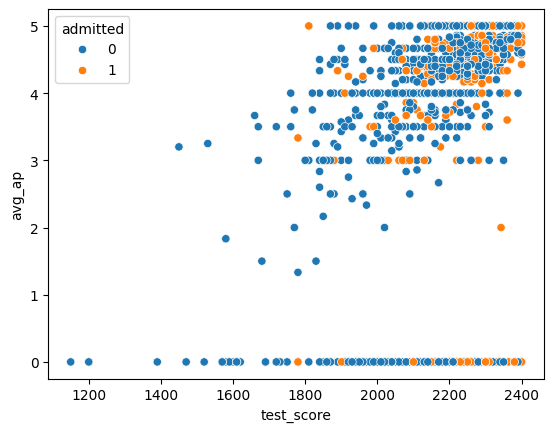

In [27]:
# plot correlational relationship between `test_score` and `avg_ap` to help get a better sense for what might be happening here
sns.scatterplot(data=college_train, x='test_score', y='avg_ap', hue='admitted')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.5** Interpret and compare the train and cv accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

In [28]:
# Display accuracies of last 2 models
print(
    "\nThe classification accuracies for 'logit2_1' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_1, acc_cv_logit2_1)
)
print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)


The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

These accuracies are very similar because the data were not scaled during preprocessing. Thus, logistic regression puts a much heavier weight on 'test_score' which is higher in magnitude and thus has more higher variance in its values, leading to an increased effect on the response. As follows, logit2_3, which is only different from logit2_1 with the addition of the 'avg_ap' predictor, is fundamentally very similar to logit2_1 since 'avg_ap' is just collinear noise without scaling.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale?</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.1**
- Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]`.
- Store the train and mean cv accuracies in `acc_train_logit3_1` and `acc_cv_logit3_1`.
- Interpret the coefficients for the binary predictors in this model.

**Hint:**
- If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [29]:
# Print statements below assume predictors used in this order
logit3_1_predictors = ["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Students applying to Harvard have a 0.2571 higher log-odds of admission than students applying to Yale holding the other predictors constant. Female students have a 0.0490 lower log-odds of admission than male students holding the other predictors constant. Lastly, minorities have a 0.7712 higher log-odds of admission than non-minorities.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [30]:
x_train = college_train[logit3_1_predictors]

logit3_1 = LogisticRegression(penalty=None, random_state=109, max_iter=1000).fit(x_train, y_train)

acc_train_logit3_1 = accuracy_score(y_train, logit3_1.predict(x_train))
acc_cv_logit3_1 = cross_val_score(logit3_1, x_train, y_train, cv=10).mean()


In [31]:
# Grab model's intercept and coefs regardless of their shape
# (which depends on how x and y were shaped)
logit3_1_intercept = np.array(logit3_1.intercept_).flatten()[0]
logit3_1_coefs = logit3_1.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_1_intercept
    )
)
for predictor, coef in zip(logit3_1_predictors, logit3_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit3_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_1, acc_cv_logit3_1)
)

The intercept and coefficients for the 'logit3_1' model are:

	intercept           -13.2402
	harvard             0.2571
	test_score          0.0052
	ap                  -0.0485
	avg_ap              -0.0304
	gpa                 0.2135
	female              -0.0490
	minority            0.7712

The classification accuracies for 'logit3_1' are:

	Train	0.7353
	CV	0.7300


In [32]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test_score", "ap"]` along with the 2 interaction terms: `harvard` with `test_score` and `harvard` with `ap`. Name the columns for these interaction terms `harvard_test_score` and `harvard_ap`. Store the train and mean cv accuracies in `acc_train_logit3_2` and `acc_cv_logit3_2`.

</div>

In [33]:
# Print statement below assumes this order of predictors
logit3_2_predictors = ["harvard", "test_score", "ap", "harvard_test_score", "harvard_ap"]

In [34]:
# your code here
college_train_predictors.loc[:, "harvard_test_score"] = college_train_predictors["harvard"] * college_train_predictors["test_score"]
college_train_predictors.loc[:, "harvard_ap"] = college_train_predictors["harvard"] * college_train_predictors["ap"]
x_train = college_train_predictors[logit3_2_predictors]

# fit Log Reg with 2 interaction terms
logit3_2 = LogisticRegression(penalty=None,random_state=109, max_iter=1000).fit(x_train, y_train)
acc_train_logit3_2 = accuracy_score(y_train, logit3_2.predict(x_train))
acc_cv_logit3_2 = cross_val_score(logit3_2, x_train, y_train, cv=10).mean()

C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\2402818795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_train_predictors.loc[:, "harvard_test_score"] = college_train_predictors["harvard"] * college_train_predictors["test_score"]
C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\2402818795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_train_predictors.loc[:, "harvard_ap"] = college_train_predictors["harvard"] * college_train_predictors["ap"]


In [35]:
# Print results of logit3_2
logit3_2_intercept = np.array(logit3_2.intercept_).flatten()[0]
logit3_2_coefs = logit3_2.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_2' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_2_intercept
    )
)

for predictor, coef in zip(logit3_2_predictors, logit3_2_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))
    
print(
    "\nThe classification accuracies for 'logit3_2' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_2, acc_cv_logit3_2)
)

The intercept and coefficients for the 'logit3_2' model are:

	intercept           -9.8464
	harvard             -2.0378
	test_score          0.0039
	ap                  0.0048
	harvard_test_score  0.0012
	harvard_ap          -0.1045

The classification accuracies for 'logit3_2' are:

	Train	0.7360
	CV	0.7353


In [36]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants:
1. someone who is applying to Harvard
2. someone who is applying to Yale (keep `test_score` and `ap` as the unknown $X$s).

The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$. Show all your steps, not just the final result.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The logistic regression model:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 \text{harvard} + \beta_2 \text{test\_score} + \beta_3 \text{avg\_ap} + \beta_4 \text{harvard\_test\_score} + \beta_5 \text{harvard\_ap} 
$$

#### Harvard Applicant

interaction terms (since 'harvard' = 1):
$$ \text{harvard\_test\_score} = \text{test\_score} $$
$$ \text{harvard\_ap} = \text{avg\_ap} $$

$$ \ln \left( \frac{P(Y=1 \mid \text{Harvard})}{1-P(Y=1 \mid \text{Harvard})} \right) = \beta_0 + \beta_1 \cdot 1 + \beta_2 \text{test\_score} + \beta_3 \text{ap} + \beta_4 \text{test\_score} + \beta_5 \text{ap} $$

$$ \ln \left( \frac{P(Y=1 \mid \text{Harvard})}{1-P(Y=1 \mid \text{Harvard})} \right) = \beta_0 + \beta_1 + (\beta_2 + \beta_4) \text{test\_score} + (\beta_3 + \beta_5) \text{ap} $$

#### Yale Applicant

'harvard' = 0

interaction terms since 'harvard' = 0
$$ \text{harvard\_test\_score} = 0 $$
$$ \text{harvard\_ap} = 0 $$


$$ \ln \left( \frac{P(Y=1 \mid \text{Yale})}{1-P(Y=1 \mid \text{Yale})} \right) = \beta_0 + \beta_1 \cdot 0 + \beta_2 \text{test\_score} + \beta_3 \text{ap} + \beta_4 \cdot 0 + \beta_5 \cdot 0 $$

$$ \ln \left( \frac{P(Y=1 \mid \text{Yale})}{1-P(Y=1 \mid \text{Yale})} \right) = \beta_0 + \beta_2 \text{test\_score} + \beta_3 \text{ap} $$

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test_score` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied to? 

Use the function for Harvard to answer the following question: if a student scored a perfect 2400 on `test_score`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

Again, you should show your work in $\LaTeX$.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

#### Harvard

$$ \ln \left( \frac{P(Y=1 \mid \text{Harvard})}{1-P(Y=1 \mid \text{Harvard})} \right) = \beta_0 + \beta_1 + (\beta_2 + \beta_4) \text{test\_score} + (\beta_3 + \beta_5) \text{ap} $$

set probability of being admitted to 0.5:

$$ \ln \left( \frac{0.5}{1-0.5} \right) = \beta_0 + \beta_1 + (\beta_2 + \beta_4) \text{test\_score} + (\beta_3 + \beta_5) \text{avg\_ap} $$

$$ 0 =\beta_0 + \beta_1 + (\beta_2 + \beta_4) \text{test\_score} + (\beta_3 + \beta_5) \text{avg\_ap}  $$

$$ \text{test\_score} = -\frac{\beta_0 + \beta_1 + (\beta_3 + \beta_5) \text{avg\_ap}}{\beta_2 + \beta_4} $$

#### Yale

$$ \ln \left( \frac{0.5}{1-0.5} \right) = \beta_0 + \beta_2 \text{test\_score} + \beta_3 \text{avg\_ap} $$

$$ 0 = \beta_0 + \beta_2 \text{test\_score} + \beta_3 \text{avg\_ap} $$

$$ \text{test\_score} = -\frac{\beta_0 + \beta_3 \text{avg\_ap}}{\beta_2} $$

#### Range of AP Tests for Harvard with 2400 Test Score
 
$$ 2400 = -\frac{\beta_0 + \beta_1 + (\beta_3 + \beta_5) \text{ap}}{\beta_2 + \beta_4} $$

$$ \text{ap} = -\frac{\beta_0 + \beta_1 + 2400 \cdot (\beta_2 + \beta_4)}{\beta_3 + \beta_5} $$

#### Range of AP Tests for Yale with 2400 Test Score

$$ 2400 = -\frac{\beta_0 + \beta_3 \text{ap}}{\beta_2}  $$

$$ \text{ap} = -\frac{\beta_0 + 2400 \cdot \beta_2}{\beta_3} $$


In [37]:
logit3_2_coefs

array([-2.03783175e+00,  3.92960777e-03,  4.75976584e-03,  1.20049539e-03,
       -1.04524431e-01])

In [38]:
min_aps = -(logit3_2_intercept + logit3_2_coefs[0] + 2400 * (logit3_2_coefs[1]+logit3_2_coefs[3]))/(logit3_2_coefs[2]+logit3_2_coefs[4])
print(f"the range of AP scores for which the probability of Harvard admission is greater than 0.5 is [{min_aps:.2f}, ∞)")

the range of AP scores for which the probability of Harvard admission is greater than 0.5 is [4.29, ∞)


In [39]:
min_aps = -(logit3_2_intercept + 2400 * (logit3_2_coefs[1]))/(logit3_2_coefs[2])
print(f"the range of AP scores for which the probability of Yale admission is greater than 0.5 is [{min_aps:.2f}, ∞)")

the range of AP scores for which the probability of Yale admission is greater than 0.5 is [87.27, ∞)


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test_score` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous question (Q3.4).  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see. You might try 'dithering' the points with a random offset so they are not all on top of one another.
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Based on the two plots, it seems that Yale had a higher density of applicants in the highest AP category: 7. For the classification boundary created in the previous question, which represents the threshold where the points equal to and greater than shown ap and test_score values have a greater than 0.5 probability of admission to *harvard*. Thus, the boundary does not hold the same properties in the Yale plot. That being said, it seems that there is a higher density of green, admitted points along the boundary in the Harvard plot than in the Yale plot, suggesting that Yale is tougher to get into with a 2400 test_score and > 4.29 ap's, which makes sense given the acceptance rates observed above in our sample data.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

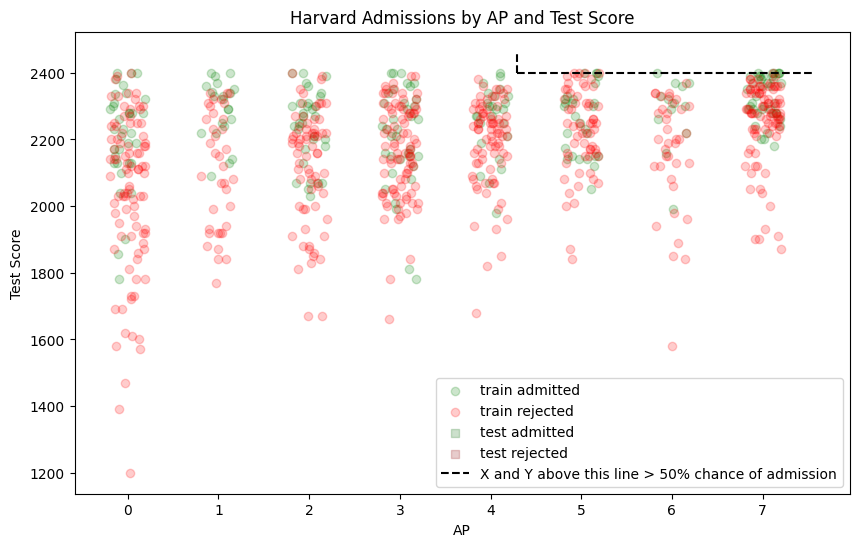

In [40]:
# dither ap points for college_train and college_test
college_train['ap_dithered'] = college_train['ap'] + np.random.uniform(-0.2, 0.2, college_train.shape[0])
college_test['ap_dithered'] = college_test['ap'] + np.random.uniform(-0.2, 0.2, college_test.shape[0])

plt.figure(figsize=(10, 6))
plt.scatter(college_train['ap_dithered'][(college_train['admitted'] == 1) & (college_train['harvard'] == 1)],
            college_train['test_score'][(college_train['admitted'] == 1) & (college_train['harvard'] == 1)], 
            c='green', label='train admitted',alpha=0.2)
plt.scatter(college_train['ap_dithered'][(college_train['admitted'] == 0) & (college_train['harvard'] == 1)],
            college_train['test_score'][(college_train['admitted'] == 0) & (college_train['harvard'] == 1)], 
            c='red', label='train rejected', alpha=0.2)
plt.scatter(college_test['ap_dithered'][(college_test['admitted'] == 1) & (college_train['harvard'] == 1)], 
            college_test['test_score'][(college_test['admitted'] == 1) & (college_train['harvard'] == 1)], 
            c='darkgreen', label='test admitted', alpha=0.2, marker='s')
plt.scatter(college_test['ap_dithered'][(college_test['admitted'] == 0) & (college_train['harvard'] == 1)], 
            college_test['test_score'][(college_test['admitted'] == 0) & (college_train['harvard'] == 1)], 
            c='darkred', label='test rejected', alpha=0.2, marker='s')
plt.xlabel('AP')
plt.ylabel('Test Score')
plt.title('Harvard Admissions by AP and Test Score')

# add decision boundary for test_score >= 2400 and ap >= 4.29
plt.vlines(4.29, 2400, plt.ylim()[1], color='black', linestyle='--', label='X and Y above this line > 50% chance of admission')
plt.hlines(2400, 4.29, plt.xlim()[1], color='black', linestyle='--')
plt.legend()



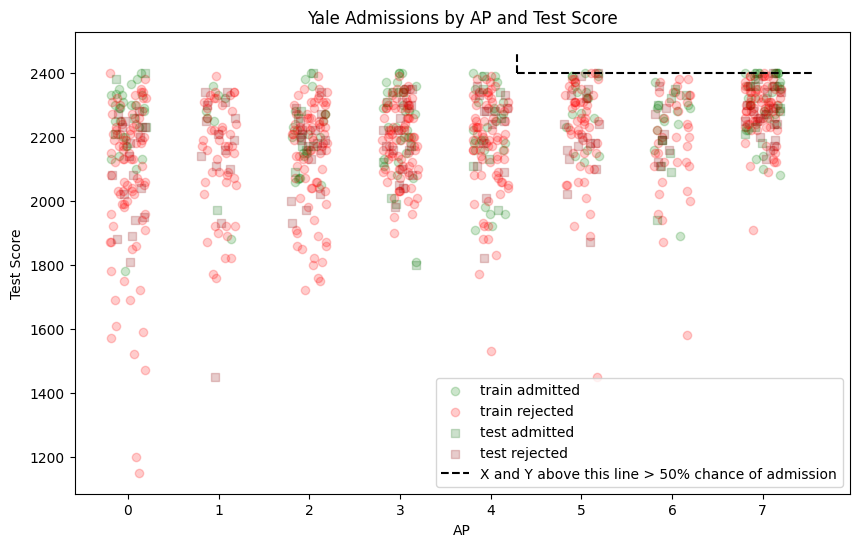

In [41]:
# same procedure for Yale
plt.figure(figsize=(10, 6))
plt.scatter(college_train['ap_dithered'][(college_train['admitted'] == 1) & (college_train['harvard'] == 0)], 
            college_train['test_score'][(college_train['admitted'] == 1) & (college_train['harvard'] == 0)], 
            c='green', label='train admitted', alpha=0.2)
plt.scatter(college_train['ap_dithered'][(college_train['admitted'] == 0) & (college_train['harvard'] == 0)], 
            college_train['test_score'][(college_train['admitted'] == 0) & (college_train['harvard'] == 0)], 
            c='red', label='train rejected', alpha=0.2)
plt.scatter(college_test['ap_dithered'][(college_test['admitted'] == 1) & (college_test['harvard'] == 0)], 
            college_test['test_score'][(college_test['admitted'] == 1) & (college_test['harvard'] == 0)], 
            c='darkgreen', label='test admitted', alpha=0.2, marker='s')
plt.scatter(college_test['ap_dithered'][(college_test['admitted'] == 0) & (college_test['harvard'] == 0)], 
            college_test['test_score'][(college_test['admitted'] == 0) & (college_test['harvard'] == 0)], 
            c='darkred', label='test rejected', alpha=0.2, marker='s')

plt.xlabel('AP')
plt.ylabel('Test Score')
plt.title('Yale Admissions by AP and Test Score')

plt.vlines(4.29, 2400, plt.ylim()[1], color='black', linestyle='--', label='X and Y above this line > 50% chance of admission')
plt.hlines(2400, 4.29, plt.xlim()[1], color='black', linestyle='--')

plt.legend()


<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test_score", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`. 

 - Store the train and mean cv accuracies in `acc_train_logit3_6` and `acc_cv_logit3_6`.
 - Display the accuracy scores.
</div>

In [42]:
# Provided code in Q3.7 will assume this order of predictors
logit3_6_predictors = ["harvard",
                       "test_score",
                       "female",
                       "minority",
                       "harvard_female",
                       "harvard_minority"
                      ]

In [43]:
# your code here
college_train_predictors['harvard_female'] = college_train_predictors['harvard'] * college_train_predictors['female']
college_train_predictors['harvard_minority'] = college_train_predictors['harvard'] * college_train_predictors['minority']
x_train = college_train_predictors[logit3_6_predictors]
logit3_6 = LogisticRegression(penalty=None,random_state=109, max_iter=10000).fit(x_train, y_train)
acc_train_logit3_6 = accuracy_score(y_train, logit3_6.predict(x_train))
acc_cv_logit3_6 = cross_val_score(logit3_6, x_train, y_train, cv=10).mean()

C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\3723222867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_train_predictors['harvard_female'] = college_train_predictors['harvard'] * college_train_predictors['female']
C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\3723222867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_train_predictors['harvard_minority'] = college_train_predictors['harvard'] * college_train_predictors['minority']


In [44]:
print(
    "\nThe classification accuracies for 'logit3_6' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_6, acc_cv_logit3_6)
)


The classification accuracies for 'logit3_6' are:

	Train	0.7353
	CV	0.7279


In [45]:
grader.check("q3.6")

q3.6 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

In [46]:
# Display results
logit3_6_intercept = np.array(logit3_6.intercept_).flatten()[0]
logit3_6_coefs = logit3_6.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_6' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_6_intercept
    )
)

for predictor, coef in zip(logit3_6_predictors, logit3_6_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'logit3_6' model are:

	intercept           -12.0507
	harvard             0.2765
	test_score          0.0049
	female              -0.1552
	minority            1.0960
	harvard_female      0.2372
	harvard_minority    -0.6214


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

being a female is associated with a 0.1552 reduction in log-odds of admission. Being a minority is associated with a 1.0960 increase in log-odds of admission. Being a female and applying to harvard is associated with a 0.2372 increase in log-odds of admission compared to Yale. On the other hand, being a minority and applying to harvard is associated with a 0.6214 reduction in log-odds of admission when compared to Yale.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.8** Based on this model, how does it appear that Harvard and Yale compare in admitting women and minorities?  Given what we've seen in our previous analysis, what might be some reasons we have to doubt the interpretation of the model's coefficients as reflecting the truth?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The model coeficients above suggest that Harvard admits more women and Yale admits more minorities given the log-odds of the interaction terms described above. Firstly, we may doubt the interpretation of these interaction terms due to potential omitted variable bias: extracurricular acitivies, essay scores, and other important predictors were not included in this logistic regression. Secondly, the small sample size could lead us to a missing data problem. For instance, perhaps women are less likely to volunteer their data upon not recieving admission than men. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test_score` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. 

1. Explain why scaling under these circumstances might be important.
2. Define a list of all non-binary predictors from the original set of 12 predictors, calling it `non_binary_predictors`.
3. Apply standardized scaling to all of these **non-binary** predictors. **For the sake of consistency, fit your scaler on just the training data. Then use it to transform both train and test.**

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set. Tests from this point on assume that `X_train` and `X_test` have been standardized with the approach outlined above. 

</div>

In [47]:
# 1. scaling the data is important because having predictors on different orders of magnitude can lead to poor model performance
# we saw this earlier when comparing efficacy of test_score and avg_ap

# your code here
non_binary_predictors = ["test_score", "ap", "avg_ap", "gpa", 'sat_subjects']

# apply standard scaler to non-binary predictors, ensuring mean 0 and std 1
scaler = StandardScaler()
X_train = college_train.drop(columns=['admitted','ap_dithered','id', 'program', 'add_info']).copy()
X_train[non_binary_predictors] = scaler.fit_transform(college_train[non_binary_predictors])
X_test[non_binary_predictors] = scaler.transform(college_test[non_binary_predictors])

print("Mean:\n", X_train[non_binary_predictors].mean())
print("Standard deviation:\n", X_train[non_binary_predictors].std())

Mean:
 test_score      5.343e-16
ap              3.800e-17
avg_ap          1.639e-16
gpa            -4.180e-16
sat_subjects    1.615e-16
dtype: float64
Standard deviation:
 test_score      1.0
ap              1.0
avg_ap          1.0
gpa             1.0
sat_subjects    1.0
dtype: float64


In [48]:
# preview summary stats after standardizing
X_train.describe()

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard
count,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000
mean,5.343e-16,3.800e-17,1.639e-16,1.615e-16,-4.180e-16,0.511,0.215,0.061,0.035,0.172,0.046,0.519
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.500,0.411,0.239,0.185,0.378,0.210,0.500
min,-6.125e+00,-1.470e+00,-2.159e+00,-2.262e+00,-9.703e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-4.540e-01,-6.091e-01,-1.203e-01,-6.917e-01,-2.008e-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.958e-01,-1.787e-01,4.205e-01,9.342e-02,3.612e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,7.275e-01,6.822e-01,6.909e-01,9.342e-02,6.167e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000
max,1.259e+00,1.543e+00,7.533e-01,2.449e+00,6.167e-01,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [49]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = range(1, 50, 2)` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, store your chosen $k$ in `best_k`, the accuracy on the best model when refit on all the training data in `knn_train_acc`, and the mean 10-fold CV accuracy of the best model in `knn_cv_acc`.
    
</div>

In [50]:
# debugging test done for above step
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index([], dtype='object')


In [51]:
ks = range(1, 50, 2)

# your code here
mean_training_accuracies = []
mean_cv_accuracies = []

y_train = college_train['admitted']

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, X_train, y_train, cv=10, return_train_score=True)
    mean_training_accuracies.append(cv_results['train_score'].mean())
    mean_cv_accuracies.append(cv_results['test_score'].mean())

best_k = ks[np.argmax(mean_cv_accuracies)]
knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)

knn_train_acc = accuracy_score(y_train, knn.predict(X_train))
knn_cv_acc = cross_val_score(knn, X_train, y_train, cv=10).mean()

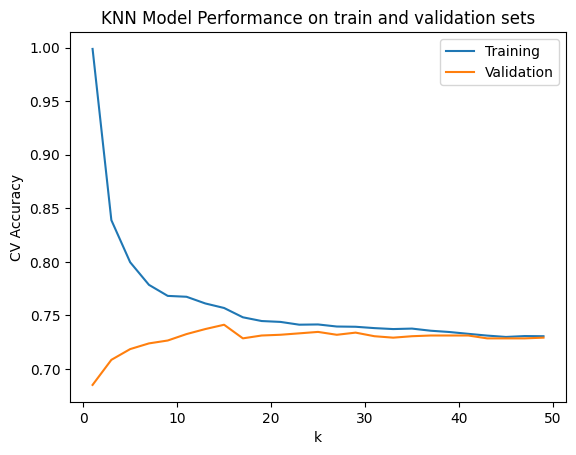

In [52]:
# Plot cross-validation results
# your code here

plt.plot(ks, mean_training_accuracies, label='Training')
plt.plot(ks, mean_cv_accuracies, label='Validation')
plt.title('KNN Model Performance on train and validation sets')
plt.xlabel('k')
plt.ylabel('CV Accuracy')
plt.legend()

In [53]:
print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(
        best_k, knn_train_acc, knn_cv_acc
    )
)
# create dict for storing test scores for each Q4 model
q4_cv_scores = {"knn_model": knn_cv_acc}

The classification accuracies for 'knn_model' where k=15 are:

	Train	0.7574
	CV	0.7413


<!-- END QUESTION -->

<div class='exercise-r'>

**Q4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Store the train mean cv accuracy in `logit_full_train_acc` and `logit_full_cv_acc`.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [54]:
# The code that prints your results assumes
# predictors were given to the model in this order
predictor_list = [
    "test_score", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

In [56]:
# your code here
logit_full = LogisticRegression(penalty=None, random_state=109, max_iter=10000).fit(X_train[predictor_list], y_train)

logit_full_train_acc = accuracy_score(y_train, logit_full.predict(X_train[predictor_list]))

logit_full_cv_acc = cross_val_score(logit_full, X_train, y_train, cv=10).mean()

In [57]:
# display your results
print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_full.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictor_list, logit_full.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_full' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_full_train_acc, logit_full_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["logit_full"] = logit_full_cv_acc

The intercept and coefficients for the 'logit_full' model are:

	intercept           -1.7415
	test_score          0.8893
	ap                  -0.1284
	avg_ap              0.0008
	sat_subjects        -0.0976
	gpa                 0.0697
	female              -0.0175
	minority            0.8088
	international       0.3067
	sports              1.0388
	harvard             0.3949
	early_app           0.6029
	alumni              0.8664

The classification accuracies for 'logit_full' are:

	Train	0.7447
	CV	0.7373


In [58]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<div class='exercise-r'>

**Q4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = np.logspace(-2, 2, 50)` and 10-fold cross-validation. Store the train and mean cross-validation accuracies in `logit_lasso_train_acc` and `logit_lasso_cv_acc`. For tuning a regularized logistic regression model, you should use `LogisticRegressionCV`. But again, to insure reproducability here, you should set `random_state=109`. 

**Hint:**
- The default solver for SKLearn's logistic regression, 'lbfgs', is not compatible with LASSO regularization, so you will need to use a different solver here. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) for guidance.

</div>

In [59]:
Cs = np.logspace(-2, 2, 50)

logit_lasso = LogisticRegressionCV(Cs=Cs, cv=10, penalty="l1", max_iter = 1000, solver="liblinear", random_state=109, scoring="accuracy").fit(X_train[predictor_list], y_train) 
logit_lasso_train_acc = logit_lasso.score(X_train[predictor_list], y_train) 
logit_lasso_cv_acc = logit_lasso.scores_[1].mean(axis=0).max()

In [60]:
# Display your results
print(
    "The intercept and coefficients for the 'logit_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_lasso.intercept_).flatten()[0]
    )
)

# Again, this code assumes predictors were given to the model
# in the order defined in `predictor_list`
for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_lasso_train_acc, logit_lasso_cv_acc)
)

# store cv score to dict for later use
q4_cv_scores["logit_lasso"] = logit_lasso_cv_acc

The intercept and coefficients for the 'logit_lasso' model are:

	intercept           -1.5207
	test_score          0.8187
	ap                  -0.0967
	avg_ap              -0.0240
	sat_subjects        -0.0689
	gpa                 0.0283
	female              -0.0029
	minority            0.6527
	international       0.0000
	sports              0.5988
	harvard             0.2628
	early_app           0.4534
	alumni              0.6012

The classification accuracies for 'logit_lasso' are:

	Train	0.7420
	CV	0.7380


In [61]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Here we assume that any predictors with zero-valued Lasso coefficients "unimportant". Store your results in `predictors_important` and `predictors_not_important`.
 
</div>

In [62]:
# NOTE: the 'liblinear' solver gave the correct accuracy and failed the below grader check but the 'saga' solver gave the opposite


predictors_important = [predictor for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()) if coef != 0]
predictors_not_important = [predictor for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()) if coef == 0]

In [63]:
# display results
print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        predictors_not_important,
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'sports', 'harvard', 'early_app', 'alumni']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['international']


In [64]:
grader.check("q4.5")

q4.5 results: All test cases passed!

<div class='exercise-r'>

**Q4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `lasso_interact`).  Again use `Cs = np.logspace(-2, 2, 50)`,  and 10-fold cross-validation with classification accuracy as the scoring metric. Record the accuracy on train and test for this model in `lasso_interact_train_acc` and `lasso_interact_test_acc`.

</div>

In [65]:
# I only drop 'international' here because that was deemed unimportant by the previous question after experimenting with different solvers
X_train_important = X_train[predictor_list].drop(columns=['international'])
X_test_important = X_test[predictor_list].drop(columns=['international'])

# get 2-way interactions for all predictors using Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interactions = poly.fit_transform(X_train_important)
X_test_interactions = poly.transform(X_test_important)


In [66]:
Cs = np.logspace(-2, 2, 50)

lasso_interact = LogisticRegressionCV(Cs=Cs, penalty='l1', solver='liblinear', cv=10, random_state=109, max_iter=1000).fit(X_train_interactions, y_train)
lasso_interact_train_acc = accuracy_score(y_train, lasso_interact.predict(X_train_interactions))
lasso_interact_cv_acc = cross_val_score(lasso_interact, X_train_interactions, y_train, cv=10).mean()
lasso_interact_test_acc = accuracy_score(y_test, lasso_interact.predict(X_test_interactions))

In [67]:
print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}\n\tTest\t{:.4f}"
    .format(lasso_interact_train_acc, lasso_interact_cv_acc, lasso_interact_test_acc)
)

# store test score to dict for later use
q4_cv_scores["lasso_interact"] = lasso_interact_cv_acc


The classification accuracies for 'logit_lasso_interact' are:

	Train	0.7547
	CV	0.7380
	Test	0.7253


<div class='exercise-r'>

**Q4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? Store these numbers in `num_important_coefs` and `num_unimportant_coefs`. 
    
</div>

In [68]:
# your code here
num_important_coefs = sum(lasso_interact.coef_.flatten() != 0)
num_unimportant_coefs = sum(lasso_interact.coef_.flatten() == 0)

In [69]:
print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        num_important_coefs + num_unimportant_coefs,
        num_important_coefs,
        num_unimportant_coefs
    )
)

Of the 66 predictors used in our 'logit_lasso_interact' model:

	44 predictors were deemed 'important' by our model
	22 predictors were deemed 'unimportant' with 0-valued coefficients


In [70]:
grader.check("q4.7")

q4.7 results: All test cases passed!

---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.1** Which of the 4 models in Question 4 performs the best based on cross-validation accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model's performance on the training data back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [71]:
# your code here
print("The CV accuracies for the 4 models in Q4 are:\n")
for key, value in q4_cv_scores.items():
    print("\t{:<25}{:.4f}".format(key, value))
print(
    "\nThe  accuracy for our original baseline \"naive\" "
    "model was {:.4f}".format(naive_train_acc)
)

The CV accuracies for the 4 models in Q4 are:

	knn_model                0.7413
	logit_full               0.7373
	logit_lasso              0.7380
	lasso_interact           0.7380

The  accuracy for our original baseline "naive" model was 0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The comparison to the naive model suggests that although each model provided some improvement, each subsequent model was barely better than guessing based on the overall probability of admission, which included all predictors, regularized predictors with optimal regularization hyperparameters determined by cross-validation, and the latter with all pairwise interactions. Based on the fact that none of these approaches resulted in cross-validated accuracy significantly higher than the naive model, we acknowledge that college admissions is a crapshoot. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.2** Draw an ROC curve for each of the four models on a single plot.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**Hint:** Use `cross_val_predict` with `method='predict_proba` to get the probability predictions required to construct the ROC curves.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

No, the ROC curves suggest that the knn model is actually the worst model rather than logit_full purely based on accuracy in 5.1. This is because the AUC is evidently lowest for knn, suggesting that the knn model cannot distinguish between classes. This could be due to knn overfitting and classifying the local data well. However, knn in this model and in general has trouble generalizing to all thresholds where probablistic logistic regression typically does a better job. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [72]:
# get predictioned probabilities using predict_proba

y_pred_knn = cross_val_predict(knn, X_train, y_train, cv=10, method='predict_proba')
y_pred_logit_full = cross_val_predict(logit_full, X_train[predictor_list], y_train, cv=10, method='predict_proba')
y_pred_logit_lasso = cross_val_predict(logit_lasso, X_train[predictor_list], y_train, cv=10, method='predict_proba')
y_pred_lasso_interact = cross_val_predict(lasso_interact, X_train_interactions, y_train, cv=10, method='predict_proba')


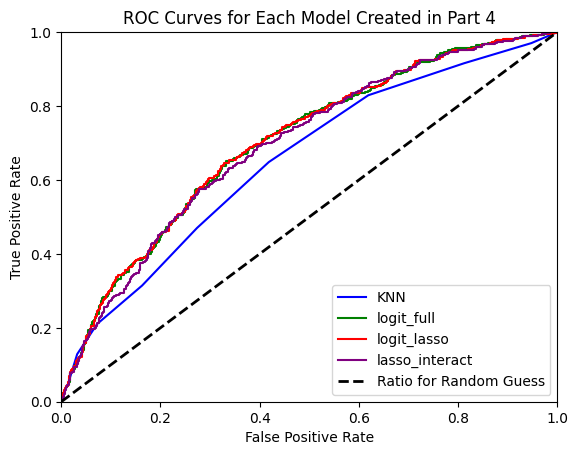

In [ ]:
from sklearn.metrics import roc_curve, auc

# get true and false positive rates for each using roc_curve as demonstrated in lab
fpr_knn, tpr_knn, _ = roc_curve(y_train, y_pred_knn[:, 1])
fpr_logit_full, tpr_logit_full, _ = roc_curve(y_train, y_pred_logit_full[:, 1])
fpr_logit_lasso, tpr_logit_lasso, _ = roc_curve(y_train, y_pred_logit_lasso[:, 1])
fpr_lasso_interact, tpr_lasso_interact, _ = roc_curve(y_train, y_pred_lasso_interact[:, 1])

plt.plot(fpr_knn, tpr_knn, color='blue', label='KNN')
plt.plot(fpr_logit_full, tpr_logit_full, color='green', label='logit_full')
plt.plot(fpr_logit_lasso, tpr_logit_lasso, color='red', label='logit_lasso')
plt.plot(fpr_lasso_interact, tpr_lasso_interact, color='purple', label='lasso_interact')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label = 'Ratio for Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Model Created in Part 4')
plt.legend()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Calculate the AUC for all 4 models and store these in `auc_list`. **The order of AUCs in the list should match the order of the model as they appear in `q4_cv_scores`.**
    
Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

No, the rankings of these 4 models based on AUC does not match the more even classification accuracy. This is because the rate of true positives to false positives is sensitive to all possible classification thresholds, making AUC a more variable measure of model goodness of fit. AUC is a better measure of performance in this case since one class, 'not admitted' in this case is far more frequent than 'admitted'.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [74]:
# your code here
roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_logit_full = auc(fpr_logit_full, tpr_logit_full)
roc_auc_logit_lasso = auc(fpr_logit_lasso, tpr_logit_lasso)
roc_auc_lasso_interact = auc(fpr_lasso_interact, tpr_lasso_interact)

# calculate each model's AUC using its ROC fpr and tpr
auc_list = [roc_auc_knn, roc_auc_logit_full, roc_auc_logit_lasso, roc_auc_lasso_interact]
    


In [75]:
print(
    "The CV accuracies & CV AUC scores for the 4 models in Q4 are:"
    "\n\n\t\t\t\tAccuracy\tAUC"
)
for (key, value), auc_value in zip(q4_cv_scores.items(), auc_list):
    print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value, auc_value))

The CV accuracies & CV AUC scores for the 4 models in Q4 are:

				Accuracy	AUC
	knn_model               0.7413		0.6530
	logit_full              0.7373		0.7013
	logit_lasso             0.7380		0.7024
	lasso_interact          0.7380		0.6946


In [76]:
grader.check("q5.3")

q5.3 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.4** Select your preferred model based on the cross-validation accuracy and AUC. For this 'final model', display the accuracy and AUC scores on the **test data**. Compare these to the accuracy and AUC score of the naive model from 1.1 when predicting on the test data. Would you offer your final model as a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale? Why or why not? What might be some consequences of the deployment of the model into the real world?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

logit_lasso is tied for the highest CV accuracy and has the highest AUC. For the final model, the accuracy and AUC are only slightly higher than the naive model in 1.1 when predicting on the test data. The model's test AUC only being around 0.06 greater than the naive model suggests that the model does not generalize well and is only slightly better than randomly guessing. So I would say no; I would not offer my final model as a publicly available tool for college applicants to use. Even with L1 regularization, there is too much noise and too little of a signal within the sample data to provide viable prediction. Some consequences of deployment of this model may be false interpretations of results. That is, some students may receive admission from the model's output, but they would obtain a prediction at almost the same level of confidence from rolling the dice based on acceptance probabilities as shown in our naive model from 1.1.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [86]:
# display accuracy and AUC scores of logit_lasso on test data
test_score_logit_lasso = accuracy_score(y_test, logit_lasso.predict(X_test[predictor_list]))

y_pred_test_logit_lasso = cross_val_predict(logit_lasso, X_test[predictor_list], y_test, cv=10, method='predict_proba')
fpr, tpr, _ = roc_curve(y_test, y_pred_test_logit_lasso[:, 1])
auc_score_logit_lasso = auc(fpr, tpr)

print(
    "The accuracy and AUC score for 'logit_lasso' on the test data are:"
    "\n\n\tAccuracy\t{:.4f}\n\tAUC\t\t{:.4f}"
    .format(test_score_logit_lasso, auc_score_logit_lasso)
)
# Calculate naive model accuracy (predicting 0 for all values in test set) 
naive_test_score = (college_test['admitted'] == 0).mean()

# naive model predicts 0 for all
naive_auc_score = roc_auc_score(college_test['admitted'], np.zeros(len(college_test)))

print(
    "The accuracy and AUC score for 'naive_model' on the test data are:"
    "\n\n\tAccuracy\t{:.4f}\n\tAUC\t\t{:.4f}"
    .format(naive_test_score, naive_auc_score)
)

The accuracy and AUC score for 'logit_lasso' on the test data are:

	Accuracy	0.7440
	AUC		0.5626
The accuracy and AUC score for 'naive_model' on the test data are:

	Accuracy	0.7307
	AUC		0.5000


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: BONUS!</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q6 (optional)** Incorporate what you've learned from the PCA and/or Missingness sections of the course to create a new, improved classification model. You could focus on improving predictive performance, inference, interpretability, or all of the above! 

Be sure to also describe your approach and analyze your results.

While this section is optional, we highly encourge you to experiment (and not just for the sake of the potential bonus points 😉).

**Note:** Though you should report the test performance of this new, "bonus" model, selecting the bonus model over the 'final model' from Q5.4 would have to be justified based on cross-validation performance, *not* test performance! 
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

This approach first analyzes any missing values in the predictor dataset, not including 'program' or 'add_info' since those variables were deemed unimportant predictors at the start of the homework. After necessarily imputing any missing values, I will analyze the 'elbow curve' of the explained variance ratio for principal components of the 12 predictors, not including interaction terms which did not increase model accuracy above in part 4. Then, looping through different numbers of components of pca, I will determine which number of components leads to the best cross-validated accuracy on the test data.

I did select this 'bonus' model with eleven cross-validated principal components over the final model from Q5.4 based on cross-validation performance. However, it should be noted that this bonus model performed worse on the test dataset than the *logit_lasso8 model, so the model from Q5 may have just gotten lucky with the test dataset...

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [87]:
# explore missingness in data
college.isnull().sum()

id                 0
admitted           0
test_score         0
ap                 0
avg_ap             0
sat_subjects       0
gpa                0
female             0
minority           0
international      0
sports             0
early_app          0
alumni             0
program          251
add_info         687
harvard            0
dtype: int64

C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\1368849061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[non_binary_predictors] = scaler.fit_transform(college_train[non_binary_predictors])
C:\Users\khcod\AppData\Local\Temp\ipykernel_9376\1368849061.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[non_binary_predictors] = scaler.transform(college_test[non_binary_predictors])


Text(0.5, 1.0, 'Cumulative Explained Variance vs. Number of Principal Components')

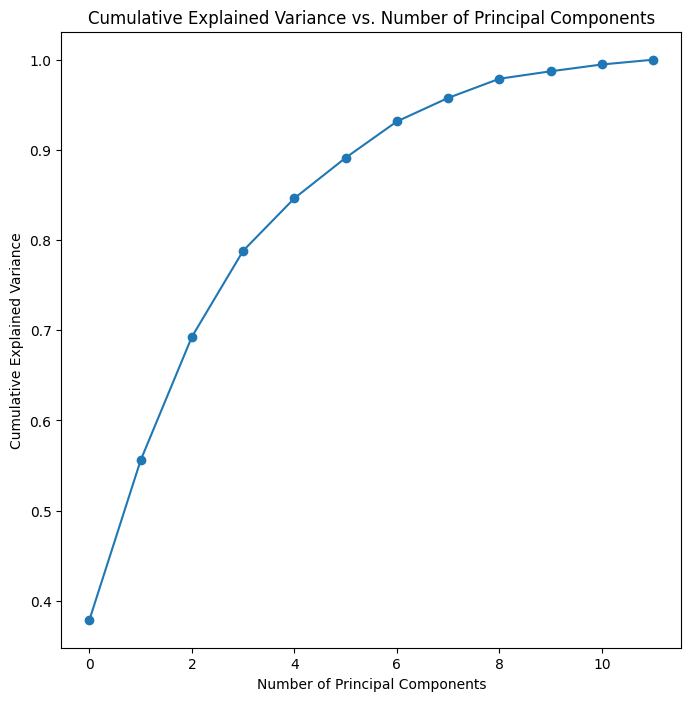

In [89]:
# get  predictors for X_train, X_test
X_train = college_train[predictor_list]
X_test = college_test[predictor_list]

scaler = StandardScaler()
X_train[non_binary_predictors] = scaler.fit_transform(college_train[non_binary_predictors])
X_test[non_binary_predictors] = scaler.transform(college_test[non_binary_predictors])

# perform PCA for train data
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# plot explained variance ratio
plt.figure(figsize=(8, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')

it looks like components 1-8 explain almost all of the variance

In [90]:
# fit logistic regression with PCA with 8 components
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

logit_pca = LogisticRegression(random_state=109, max_iter=1000, solver='liblinear').fit(X_train_pca, y_train)
logit_pca_train_acc = accuracy_score(y_train, logit_pca.predict(X_train_pca))
logit_pca_cv_acc = cross_val_score(logit_pca, X_train_pca, y_train, cv=10).mean()

print(
    "The classification accuracies for 'logit_pca' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV Validation\t{:.4f}"
    .format(logit_pca_train_acc, logit_pca_cv_acc)
)

The classification accuracies for 'logit_pca' are:

	Train	0.7386
	CV Validation	0.7293


In [97]:
# Test PCA with n_components values
for n in range(1, 13):
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    logit_pca = LogisticRegression(random_state=109, max_iter=10000).fit(X_train_pca, y_train)
    logit_pca_train_acc = accuracy_score(y_train, logit_pca.predict(X_train_pca))
    logit_pca_cv_acc = cross_val_score(logit_pca, X_train_pca, y_train, cv=10).mean()
    print(
        f"PCA n_components={n}:"
        f"\n\tTrain Accuracy: {logit_pca_train_acc:.4f}"
        f"\n\tCV Accuracy: {logit_pca_cv_acc:.4f}\n"
    )

PCA n_components=1:
	Train Accuracy: 0.7299
	CV Accuracy: 0.7300

PCA n_components=2:
	Train Accuracy: 0.7299
	CV Accuracy: 0.7300

PCA n_components=3:
	Train Accuracy: 0.7299
	CV Accuracy: 0.7300

PCA n_components=4:
	Train Accuracy: 0.7313
	CV Accuracy: 0.7300

PCA n_components=5:
	Train Accuracy: 0.7333
	CV Accuracy: 0.7299

PCA n_components=6:
	Train Accuracy: 0.7333
	CV Accuracy: 0.7286

PCA n_components=7:
	Train Accuracy: 0.7320
	CV Accuracy: 0.7293

PCA n_components=8:
	Train Accuracy: 0.7393
	CV Accuracy: 0.7293

PCA n_components=9:
	Train Accuracy: 0.7400
	CV Accuracy: 0.7360

PCA n_components=10:
	Train Accuracy: 0.7406
	CV Accuracy: 0.7366

PCA n_components=11:
	Train Accuracy: 0.7467
	CV Accuracy: 0.7413

PCA n_components=12:
	Train Accuracy: 0.7426
	CV Accuracy: 0.7340



In [99]:
# report test performance with 11 components 
pca = PCA(n_components=11)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

logit_pca_final = LogisticRegression(random_state=109, max_iter=10000).fit(X_train_pca, y_train)
logit_pca_test_acc = accuracy_score(y_test, logit_pca_final.predict(X_test_pca))

print(
        f"PCA n_components={11}:"
        f"\n\tTest Accuracy: {logit_pca_test_acc:.4f}\n"
    )

PCA n_components=11:
	Test Accuracy: 0.7280



<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [ ]:
hours_spent_on_hw = 19

In [114]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [96]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 32.41 minutes for this notebook to run


🌈 **This concludes HW5. Thank you!**

[Return to contents](#contents)